## Task

You are provided with registration data of 2298 mobile subscribers at base stations within one month.  

The data format is as follows:
* `lac`: Location Area Code (LAC). The Location Area Code, abbreviated as LAC is the unique number given to each location area within the network. The served area of a cellular radio access network is usually divided into location areas, consisting of one or several radio cells.
* `cid`: Cell ID (CID). A GSM Cell ID (CID) is a generally unique number used to identify each base transceiver station (BTS) or sector of a BTS within a location area code (LAC) if not within a GSM network.
* `ts`: UNIX-time. Means the number of seconds elapsed from 01.01.1970 to the event in question.
* `fulldate`: Date
* `hash_id`: Mobile user ID

The data is divided into two parts by the `fulldate` field:
1) from the 1st to the 14th of the month;
2) from the 16th to the 30th of the month.

Each part uses its own system for assigning identifiers to subscribers, which leads to the fact that the same subscriber in different parts of the sample has different identifiers: from 1st to 14th - one, from 16th to 30th - another.

Develop an algorithm that will establish a unique correspondence between identifiers from the first and second parts of the sample.  

The expected result is a table of correspondences of the form `id1 - id2` in *.csv format, where `id1` is an identifier from the first part of the selection, `id2` is an identifier from the second part of the selection.  
To help you, a standard of 491 pairs of `id1` and `id2` is provided. You need to determine the remaining 1000+ matches.

## Imports

In [1]:
# !pip install category_encoders eli5

In [2]:
import os
import sys
import warnings

import eli5
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
from utils.memory_utils import reduce_mem_usage
from utils.time_utils import get_time_features, time_features
from utils.train_utils import fit_and_score, tf_idf_transform

In [4]:
sns.set(rc={"figure.dpi": 100, "savefig.dpi": 300})
sns.set_context("notebook")
sns.set_style("ticks")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tqdm.pandas()

In [5]:
ConvergenceWarning("ignore")

warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ[
        "PYTHONWARNINGS"
    ] = "ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning"

In [6]:
SEED = 42

## Paths

### Input

In [7]:
RELATIVE_PATH = "../data/"

In [8]:
DATA_PATH_PARQUET = os.path.join(RELATIVE_PATH, "01_data.parquet")
REFERENCE_PATH_PARQUET = os.path.join(RELATIVE_PATH, "02_etalon.parquet")

### Output

In [9]:
FINAL_MAPPING_PATH_CSV = os.path.join(RELATIVE_PATH, "final_mapping.csv")

## Loading Data

I've re-saved files in `parquet` format for faster loading (6x) and less memory consumption while storing (5x) (notebook `01_optimizing_storage.ipynb`)

In [10]:
data = pd.read_parquet(DATA_PATH_PARQUET)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9153692 entries, 0 to 9153691
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lac       int64  
 1   cid       int64  
 2   ts        float64
 3   fulldate  object 
 4   hash_id   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 349.2+ MB


In [11]:
reference = pd.read_parquet(REFERENCE_PATH_PARQUET)
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id1     491 non-null    int64
 1   id2     491 non-null    int64
dtypes: int64(2)
memory usage: 7.8 KB


## Dataset Overview

In [12]:
data.sample(n=10, random_state=SEED)

,lac,cid,ts,fulldate,hash_id
5020211,9732,198732291,1.538248e+09,2018-09-29,2193027
1751775,9731,198722053,1.536042e+09,2018-09-04,1167117
6373931,9934,197611523,1.537859e+09,2018-09-25,2129824
7344952,9745,10301,1.537101e+09,2018-09-16,2893856
5139826,9713,198838786,1.537440e+09,2018-09-20,2677662
8988177,7716,60325,1.537241e+09,2018-09-18,2862389
7552833,9716,198688516,1.537810e+09,2018-09-24,2521886
4635300,9937,249030668,1.537884e+09,2018-09-25,2571471
64115,9716,31422,1.536637e+09,2018-09-11,1213812
6502056,9785,198067460,1.537098e+09,2018-09-16,2841115


## Dataset Close Look

In this section, let's look at what columns we have, what type they are, how many non-zero values, etc.

### Reference

<AxesSubplot:>

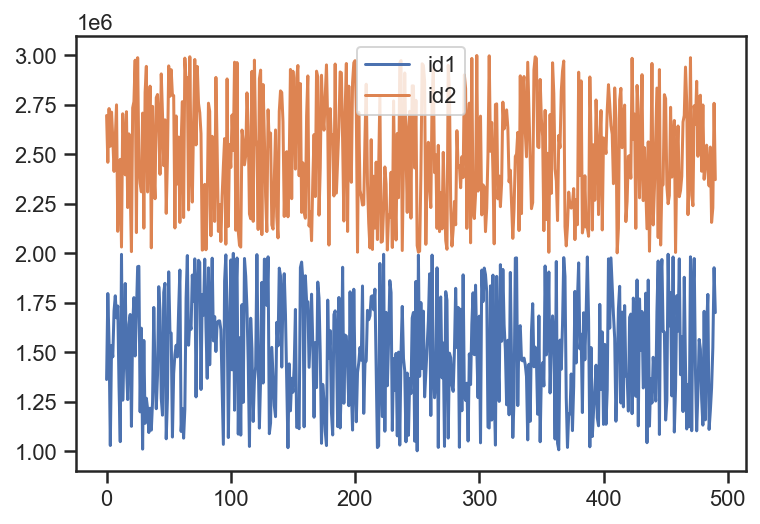

In [13]:
reference.plot()

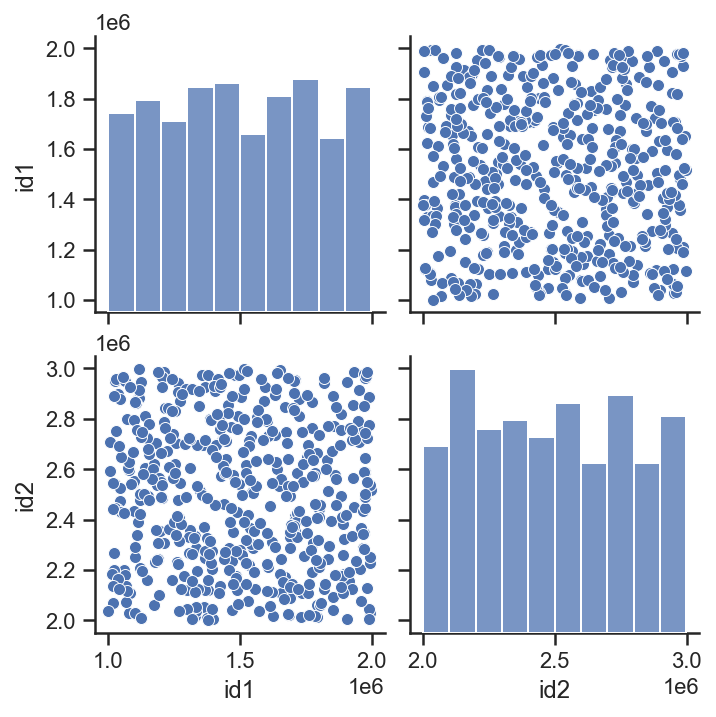

In [14]:
sns.pairplot(reference)

array([[<AxesSubplot:title={'center':'id1'}>,
        <AxesSubplot:title={'center':'id2'}>]], dtype=object)

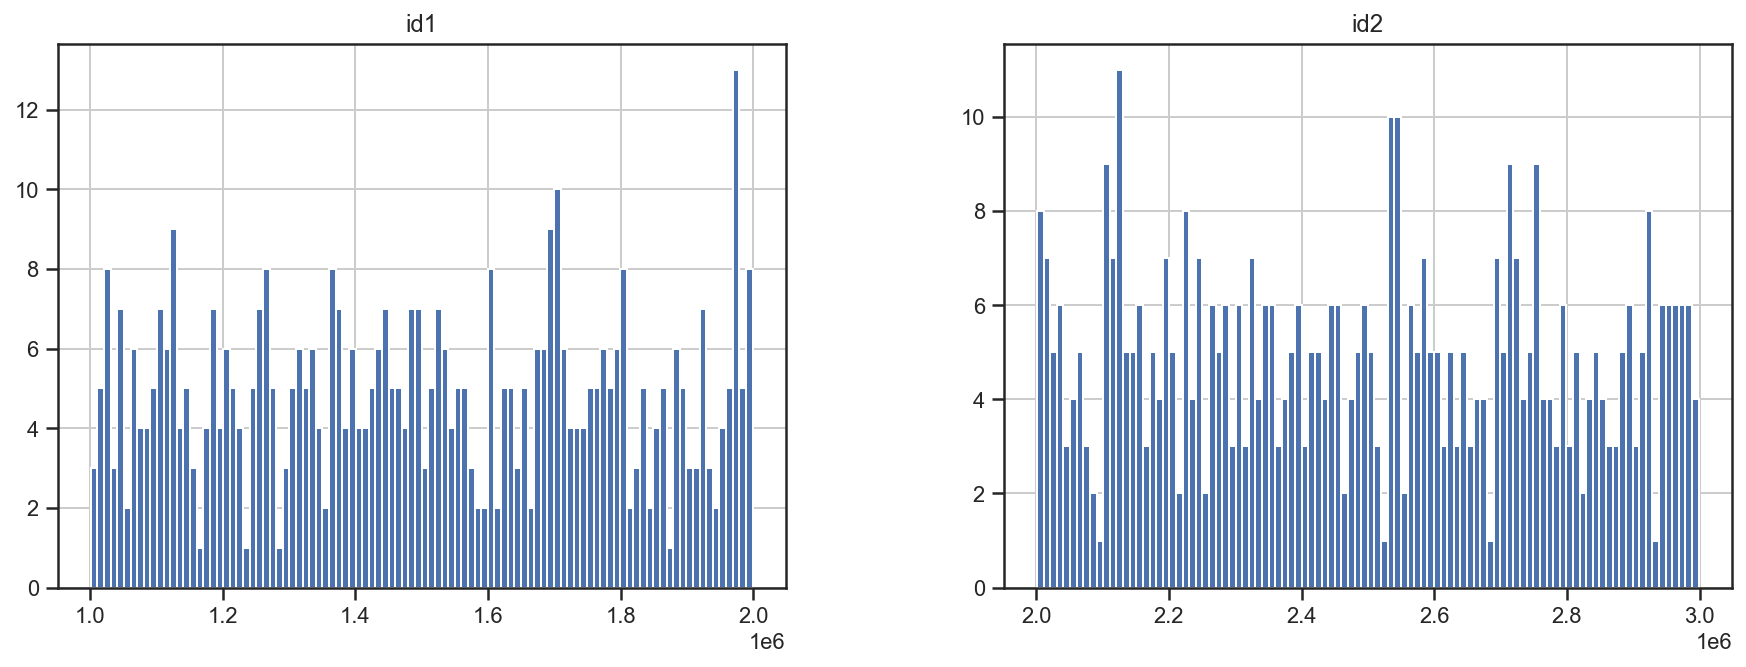

In [15]:
reference.hist(figsize=(15, 5), bins=100)

We will not be able to find any dependencies in reference's data

### Data

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9153692 entries, 0 to 9153691
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lac       int64  
 1   cid       int64  
 2   ts        float64
 3   fulldate  object 
 4   hash_id   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 349.2+ MB


Fields:
* `lac`: Location Area Code (LAC). The Location Area Code, abbreviated as LAC is the unique number given to each location area within the network. The served area of a cellular radio access network is usually divided into location areas, consisting of one or several radio cells.
* `cid`: Cell ID (CID). A GSM Cell ID (CID) is a generally unique number used to identify each base transceiver station (BTS) or sector of a BTS within a location area code (LAC) if not within a GSM network.
* `ts`: UNIX-time. Means the number of seconds elapsed from 01.01.1970 to the event in question.
* `fulldate`: Date
* `hash_id`: Mobile user ID

#### `lac`

In [17]:
data["lac"].describe(
    percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]
).apply(lambda x: format(x, "f"))

count    9153692.000000
mean        8950.529107
std         1377.873462
min         3302.000000
1%          5015.000000
5%          5061.000000
25%         7752.000000
50%         9716.000000
75%         9772.000000
95%         9935.000000
99%         9942.000000
99.9%       9976.000000
max        43000.000000
Name: lac, dtype: object

<AxesSubplot:>

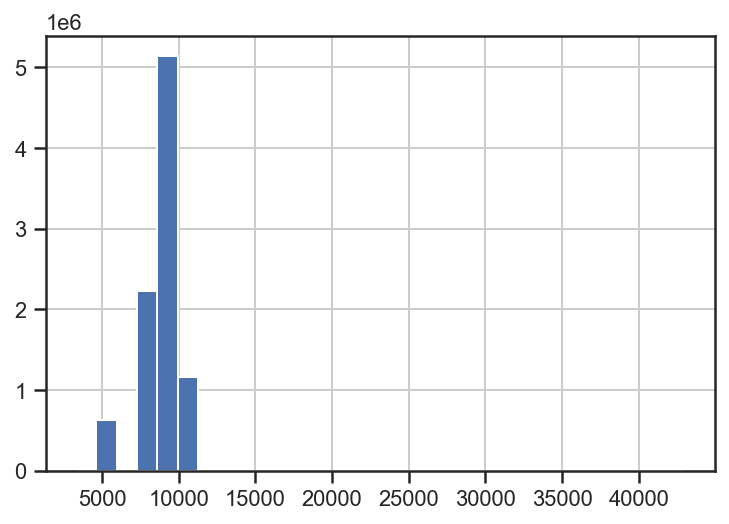

In [18]:
data["lac"].hist(bins=30)

<AxesSubplot:>

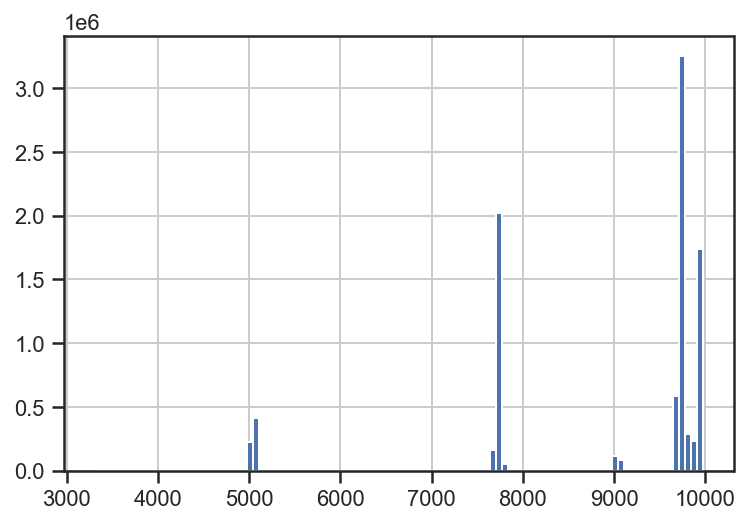

In [19]:
data[data["lac"] <= 9976]["lac"].hist(bins=100)

There are only a few popular ranges of values for `lac`

In [20]:
data["lac"].value_counts()

9716     951184
9734     567379
7716     537042
9916     534000
9934     490347
          ...  
23131         1
23120         1
9109          1
9560          1
9101          1
Name: lac, Length: 364, dtype: int64

We can see that we have 364 unique locations, although some of them are not very popular, while some of them are.

There are some outliers

In [21]:
data[data["lac"] > 9976]["lac"].value_counts()

41800    31
43000    22
41801    19
23130     4
23111     3
23141     2
23120     1
23131     1
Name: lac, dtype: int64

#### `cid`

In [22]:
data["cid"].value_counts()

3323         33830
33104        24805
3253         23217
33102        21505
14642        19027
             ...  
61225            1
36645            1
231806230        1
197768708        1
28596            1
Name: cid, Length: 75052, dtype: int64

We have a lot of unique values

<AxesSubplot:>

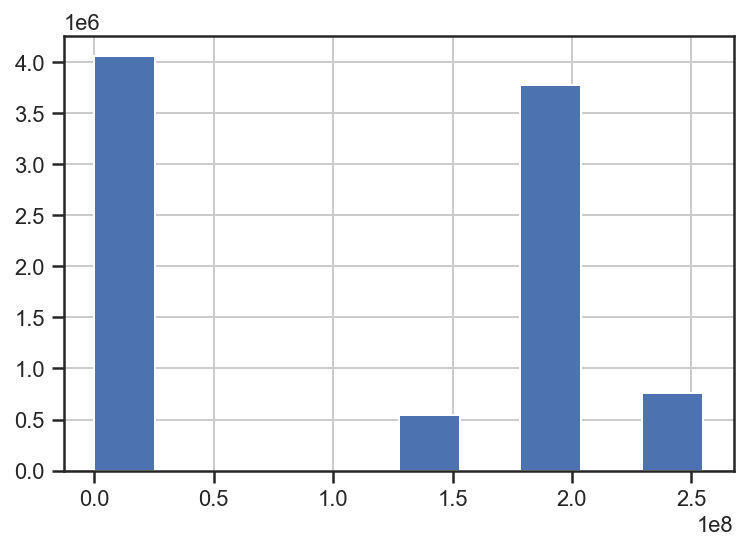

In [23]:
data["cid"].hist()

In [24]:
data["cid"].describe(
    percentiles=[0.01, 0.05, 0.25, 0.36, 0.3694, 0.3695, 0.5, 0.75, 0.95, 0.99, 0.999]
).apply(lambda x: format(x, "f"))

count       9153692.000000
mean      110670504.759660
std        98943536.660267
min               1.000000
1%              517.000000
5%             2317.000000
25%           32048.000000
36%           62477.000000
36.94%        65522.000000
36.95%       858479.000000
50%       129608451.000000
75%       198014732.000000
95%       232057857.000000
99%       253467908.000000
99.9%     254263301.000000
max       254855684.000000
Name: cid, dtype: object

Strange difference between 36.94 and 36.95 percentile. Let's find out more about `cid`

##### Fixing CID

Long cell ID vs. short cell ID  
The formula for the long cell ID is as follows:  
Long CID = 65536 * RNC + CID  

RNC: the Radio Network Controller  
CID: a short cell ID (an integer in the range of 0 to 65535)  

If you have the Long CID, you can get RNC and CID in the following way:  
RNC = Long CID / 65536 (integer division)  
CID = Long CID mod 65536 (modulo operation)  

Example for long cell ID 66808694:  
RNC = 66808694 / 65536 = 1019  
CID = 66808694 mod 65536 = 27510  

Aha. We have Long and Short CID mixed. Let's make all Long CID Short.

In [25]:
data["cid"] = data["cid"].progress_apply(
    lambda cid: cid % 65536 if cid > 65535 else cid
)

  0%|          | 0/9153692 [00:00<?, ?it/s]

In [26]:
data["cid"].describe().apply(lambda x: format(x, "f"))

count    9153692.000000
mean       28729.860331
std        19928.071245
min            1.000000
25%        10273.000000
50%        28965.000000
75%        45571.000000
max        65534.000000
Name: cid, dtype: object

In [27]:
data["cid"].value_counts()

3323     33830
25861    26781
33104    24805
30466    23887
3253     23217
         ...  
42709        1
61044        1
23468        1
15264        1
27058        1
Name: cid, Length: 38926, dtype: int64

Now it looks better

<AxesSubplot:>

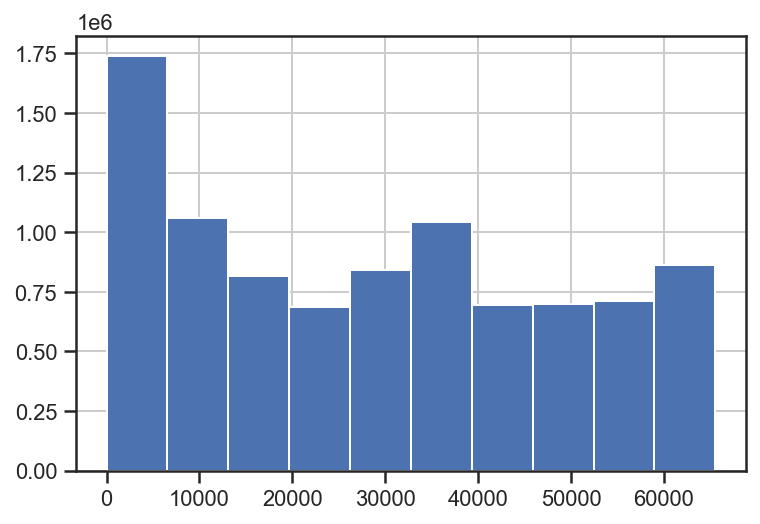

In [28]:
data["cid"].hist()

#### `lac` and `cid` interaction

In [29]:
lac_cid_group = (
    pd.DataFrame(data.groupby(["lac", "cid"])["cid"].count())
    .rename(columns={"cid": "count"})
    .reset_index()
)

In [30]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(lac_cid_group.sort_values(by=["cid", "lac"]).iloc[:20])

,lac,cid,count
3,5000,1,27
10986,5029,1,16
13378,5037,1,2
15882,5047,1,33
46517,9000,1,71
46681,9001,1,1
46872,9002,1,1
53435,9054,1,25
54197,9071,1,35
57540,9704,1,17


The same `cid` can belong to different `lac`, which is strange. But it can be fine, if for every `lac` there is its own `cid`

In [31]:
lac_cid_group.shape

(82191, 3)

There are 82191 unique combinations of `lac` and `cid`

Let's create a feature, where `lac` and `cid` will be together

In [32]:
data["lac_cid"] = data["lac"].astype("str") + "_" + data["cid"].astype("str")

#### `ts`

`ts` column will be transformed into `datetime` format in the next section

#### `fulldate`

`fulldate` column will be transformed into `datetime` format in the next section

#### `hash_id`

In [33]:
unique_hash_ids = data["hash_id"].unique()

In [34]:
data["hash_id"].value_counts()

1088711    34138
2187102    30128
2674156    18115
2102524    13183
1819111    12862
           ...  
1968066        4
1255062        4
1754876        3
1534909        2
1570683        1
Name: hash_id, Length: 4542, dtype: int64

We know that there are reference out of $491$ pairs, which makes $982$ IDs that have direct matching

We also know that there are $1000+$ more pairs.

Maybe we have **IDs** that **don't have a match**. 

## Data transformation

### Saving a bit of memory

As soon as our dataset is not optimally stored, we can optimize memory consumption.

In [35]:
fulldate = data["fulldate"]
data = reduce_mem_usage(data.drop("fulldate", axis=1))
data["fulldate"] = fulldate

Memory usage of dataframe is 349.19 MB


  0%|          | 0/5 [00:00<?, ?it/s]

Memory usage after optimization is: 177.24 MB
Decreased by 49.2%


### `ts` and `fulldate`

#### Transforming `ts` and `fulldate` into `datetime` format

We know that `ts` column is the number of seconds elapsed from 01.01.1970 to the event.  
Let's encode it to `datetime` format.

In [36]:
data.insert(3, "datetime_ts", pd.to_datetime(data["ts"], unit="s"))
data.drop("ts", axis=1, inplace=True, errors="ignore")
data["fulldate"] = pd.to_datetime(data["fulldate"])

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9153692 entries, 0 to 9153691
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   lac          int32         
 1   cid          int32         
 2   datetime_ts  datetime64[ns]
 3   hash_id      int32         
 4   lac_cid      category      
 5   fulldate     datetime64[ns]
dtypes: category(1), datetime64[ns](2), int32(3)
memory usage: 282.0 MB


#### Date and Time features extraction

In [38]:
datetime_features, datetime_feature_names = get_time_features(
    data["fulldate"], data["datetime_ts"]
)

In [39]:
datetime_features.head()

,hour,morning,day,evening,night,weekday,weekend
0,7,1,0,0,0,4,0
1,7,1,0,0,0,5,0
2,9,1,0,0,0,2,0
3,7,1,0,0,0,7,1
4,9,1,0,0,0,3,0


In [40]:
data = pd.concat([data, datetime_features], axis=1)

#### Checking data integrity

In [41]:
data[(data["fulldate"].dt.day == 15) | (data["fulldate"].dt.day == 31)]

,lac,cid,datetime_ts,hash_id,lac_cid,fulldate,hour,morning,day,evening,night,weekday,weekend


As promised, the data was split into two parts by day: 
* from the $1^{st}$ to the $14^{th}$ of the month
* from the $16^{th}$ to the $30^{th}$ of the month  

So there are no $15$ and $31$ days in the sample. It's fine.

In [42]:
sorted(data["fulldate"].dt.date.unique())

[datetime.date(2018, 9, 1),
 datetime.date(2018, 9, 2),
 datetime.date(2018, 9, 3),
 datetime.date(2018, 9, 4),
 datetime.date(2018, 9, 5),
 datetime.date(2018, 9, 6),
 datetime.date(2018, 9, 7),
 datetime.date(2018, 9, 8),
 datetime.date(2018, 9, 9),
 datetime.date(2018, 9, 10),
 datetime.date(2018, 9, 11),
 datetime.date(2018, 9, 12),
 datetime.date(2018, 9, 13),
 datetime.date(2018, 9, 14),
 datetime.date(2018, 9, 16),
 datetime.date(2018, 9, 17),
 datetime.date(2018, 9, 18),
 datetime.date(2018, 9, 19),
 datetime.date(2018, 9, 20),
 datetime.date(2018, 9, 21),
 datetime.date(2018, 9, 22),
 datetime.date(2018, 9, 23),
 datetime.date(2018, 9, 24),
 datetime.date(2018, 9, 25),
 datetime.date(2018, 9, 26),
 datetime.date(2018, 9, 27),
 datetime.date(2018, 9, 28),
 datetime.date(2018, 9, 29),
 datetime.date(2018, 9, 30)]

We have one full month - $\text{September 2018}$, except $15$ and $31$ days, as stated before.

There are $\text{61 297}$ records for which date from `fulldate` column doesn't match the date, which was obtained from `ts` column.  
Not fine!

In [43]:
data[data["fulldate"].dt.date != data["datetime_ts"].dt.date]

,lac,cid,datetime_ts,hash_id,lac_cid,fulldate,hour,morning,day,evening,night,weekday,weekend
0,7755,35950,2018-09-08 07:10:56,1361396,7755_35950,2018-09-13,7,1,0,0,0,4,0
1,7755,35950,2018-09-08 07:10:56,1361396,7755_35950,2018-09-14,7,1,0,0,0,5,0
2,7752,19203,2018-09-03 09:31:44,1361396,7752_19203,2018-09-04,9,1,0,0,0,2,0
3,7755,35950,2018-09-08 07:10:56,1361396,7755_35950,2018-09-09,7,1,0,0,0,7,1
4,7752,19203,2018-09-03 09:31:44,1361396,7752_19203,2018-09-05,9,1,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9153681,7746,6551,2018-09-24 16:14:56,2241318,7746_6551,2018-09-26,16,0,1,0,0,3,0
9153684,7716,11870,2018-09-13 18:22:56,2241318,7716_11870,2018-09-16,18,0,1,0,0,7,1
9153685,7716,11870,2018-09-13 18:22:56,2241318,7716_11870,2018-09-19,18,0,1,0,0,3,0
9153686,7746,6551,2018-09-24 16:14:56,2241318,7746_6551,2018-09-28,16,0,1,0,0,5,0


And there are some records for which splitting in two groups could be ambiguous.  
For example, `fulldate` is `2018-09-19` and `datetime_ts` is `2018-09-13`. Using one column data should be in one partition and using other column data should be in another partition.

### User journeys creation from `lac_cid` feature

I've found out that we can create a list of `lac_cid` values for every user in sorted order (by `datetime_ts` column).  
It will show how every specific user was registered on different base stations along the way of time.

For example, let's take one `hash_id`

In [44]:
unique_hash_ids[0]

1361396

And look at the path for user $1361396$

In [45]:
" ".join(
    data[data["hash_id"] == 1361396].sort_values(by="datetime_ts")["lac_cid"].values
)

'5007_7088 7752_19207 7752_19203 7752_19203 7752_19203 7752_19207 7752_19207 7752_19203 7755_23103 7755_23103 7755_23103 7755_35950 7755_35950 7755_35950 7755_35950 7755_35950 7755_35950 7755_35950'

Let's do this for every user in our dataset.  
We can save the whole path for every user, but probably we will be good with only part of it.  

The length of the path could be some arbitrary number like 100 or 200, or it could be some statistic, like mean/median/specific percentile of the length distribution across users.  

For now, let's take median value for the dataset. 

In [46]:
user_journeys = {}

In [47]:
n_journeys = int(data.groupby("hash_id")["lac_cid"].count().median())
n_journeys

1450

In [48]:
for user in tqdm(unique_hash_ids, desc="Creating user journeys"):
    user_journeys[user] = " ".join(
        data[data["hash_id"] == user]
        .sort_values(by="datetime_ts")["lac_cid"]
        .values[:n_journeys]
    )

Creating user journeys:   0%|          | 0/4542 [00:00<?, ?it/s]

Of course, we'll create a column based on this data.

In [49]:
data["user_journey"] = data["hash_id"].map(user_journeys)

### Datetime based features

Currently, these features are not used in the solution.

In [50]:
data.sample(10, random_state=SEED)

,lac,cid,datetime_ts,hash_id,lac_cid,fulldate,hour,morning,day,evening,night,weekday,weekend,user_journey
5020211,9732,27139,2018-09-29 19:07:44,2193027,9732_27139,2018-09-29,19,0,0,1,0,6,1,9732_27139 9732_27168 9732_27139 9732_27168 97...
1751775,9731,16901,2018-09-04 06:19:44,1167117,9731_16901,2018-09-04,6,0,0,0,1,2,0,9091_52008 9060_16643 9091_52008 5091_64312 90...
6373931,9934,20483,2018-09-25 07:00:16,2129824,9934_20483,2018-09-25,7,1,0,0,0,2,0,7716_38835 9716_31069 7716_48445 9716_61958 77...
7344952,9745,10301,2018-09-16 12:33:04,2893856,9745_10301,2018-09-16,12,0,1,0,0,7,1,7716_3323 7716_9553 9716_34606 7716_3323 7716_...
5139826,9713,2562,2018-09-20 10:35:44,2677662,9713_2562,2018-09-20,10,1,0,0,0,4,0,9716_30230 9716_17210 9716_3145 7716_3155 9716...
8988177,7716,60325,2018-09-18 03:22:40,2862389,7716_60325,2018-09-18,3,0,0,0,1,2,0,7716_60325 7716_9553 7716_60325 7716_9553 7716...
7552833,9716,48900,2018-09-24 17:27:28,2521886,9716_48900,2018-09-24,17,0,1,0,0,1,0,7730_460 7716_2147 9716_30220 9716_36733 7730_...
4635300,9937,59404,2018-09-25 13:54:08,2571471,9937_59404,2018-09-25,13,0,1,0,0,2,0,9758_23298 9734_14852 9758_23298 9734_14849 97...
64115,9716,31422,2018-09-11 03:33:20,1213812,9716_31422,2018-09-11,3,0,0,0,1,2,0,7716_60475 9716_31422 7716_60475 9716_31422 77...
6502056,9785,17668,2018-09-16 11:46:08,2841115,9785_17668,2018-09-16,11,1,0,0,0,7,1,9716_9218 9716_9218 7716_3579 7716_3579 9716_3...


In [51]:
hour_tf = time_features(data, column="hour", prefix="reg_hour", add_total_count=True)
hour_tf

hour,reg_hour_0,reg_hour_1,reg_hour_2,reg_hour_3,reg_hour_4,reg_hour_5,reg_hour_6,reg_hour_7,reg_hour_8,reg_hour_9,...,reg_hour_15,reg_hour_16,reg_hour_17,reg_hour_18,reg_hour_19,reg_hour_20,reg_hour_21,reg_hour_22,reg_hour_23,reg_hour_total
hash_id,,,,,,,,,,,,,,,,,,,,,
1000773,0.000000,0.000000,0.017241,0.025862,0.008621,0.017241,0.034483,0.077586,0.051724,0.077586,...,0.051724,0.068966,0.077586,0.060345,0.068966,0.094828,0.008621,0.000000,0.000000,116.0
1000808,0.041284,0.041284,0.041284,0.041284,0.050459,0.055046,0.050459,0.013761,0.018349,0.032110,...,0.055046,0.059633,0.045872,0.055046,0.059633,0.059633,0.059633,0.055046,0.050459,218.0
1000868,0.028777,0.028777,0.032374,0.035971,0.035971,0.043165,0.046763,0.039568,0.039568,0.046763,...,0.043165,0.050360,0.046763,0.050360,0.046763,0.046763,0.043165,0.039568,0.050360,278.0
1001103,0.027027,0.000000,0.000000,0.000000,0.081081,0.081081,0.081081,0.081081,0.081081,0.081081,...,0.054054,0.054054,0.000000,0.000000,0.000000,0.000000,0.000000,0.054054,0.000000,37.0
1001168,0.043103,0.025862,0.017241,0.051724,0.051724,0.068966,0.025862,0.034483,0.017241,0.025862,...,0.043103,0.060345,0.051724,0.043103,0.025862,0.034483,0.051724,0.051724,0.060345,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998617,0.000000,0.008475,0.008475,0.033898,0.042373,0.033898,0.050847,0.076271,0.076271,0.059322,...,0.008475,0.025424,0.042373,0.076271,0.076271,0.110169,0.050847,0.000000,0.000000,118.0
2999034,0.005405,0.005405,0.016216,0.054054,0.059459,0.054054,0.059459,0.070270,0.064865,0.059459,...,0.043243,0.059459,0.064865,0.048649,0.021622,0.010811,0.005405,0.005405,0.005405,185.0
2999248,0.008163,0.016327,0.008163,0.036735,0.053061,0.057143,0.053061,0.057143,0.057143,0.053061,...,0.053061,0.057143,0.053061,0.048980,0.044898,0.016327,0.028571,0.028571,0.008163,245.0


In [52]:
weekday_tf = time_features(
    data, column="weekday", prefix="reg_weekday", add_total_count=True
)
hour_tf

hour,reg_hour_0,reg_hour_1,reg_hour_2,reg_hour_3,reg_hour_4,reg_hour_5,reg_hour_6,reg_hour_7,reg_hour_8,reg_hour_9,...,reg_hour_15,reg_hour_16,reg_hour_17,reg_hour_18,reg_hour_19,reg_hour_20,reg_hour_21,reg_hour_22,reg_hour_23,reg_hour_total
hash_id,,,,,,,,,,,,,,,,,,,,,
1000773,0.000000,0.000000,0.017241,0.025862,0.008621,0.017241,0.034483,0.077586,0.051724,0.077586,...,0.051724,0.068966,0.077586,0.060345,0.068966,0.094828,0.008621,0.000000,0.000000,116.0
1000808,0.041284,0.041284,0.041284,0.041284,0.050459,0.055046,0.050459,0.013761,0.018349,0.032110,...,0.055046,0.059633,0.045872,0.055046,0.059633,0.059633,0.059633,0.055046,0.050459,218.0
1000868,0.028777,0.028777,0.032374,0.035971,0.035971,0.043165,0.046763,0.039568,0.039568,0.046763,...,0.043165,0.050360,0.046763,0.050360,0.046763,0.046763,0.043165,0.039568,0.050360,278.0
1001103,0.027027,0.000000,0.000000,0.000000,0.081081,0.081081,0.081081,0.081081,0.081081,0.081081,...,0.054054,0.054054,0.000000,0.000000,0.000000,0.000000,0.000000,0.054054,0.000000,37.0
1001168,0.043103,0.025862,0.017241,0.051724,0.051724,0.068966,0.025862,0.034483,0.017241,0.025862,...,0.043103,0.060345,0.051724,0.043103,0.025862,0.034483,0.051724,0.051724,0.060345,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998617,0.000000,0.008475,0.008475,0.033898,0.042373,0.033898,0.050847,0.076271,0.076271,0.059322,...,0.008475,0.025424,0.042373,0.076271,0.076271,0.110169,0.050847,0.000000,0.000000,118.0
2999034,0.005405,0.005405,0.016216,0.054054,0.059459,0.054054,0.059459,0.070270,0.064865,0.059459,...,0.043243,0.059459,0.064865,0.048649,0.021622,0.010811,0.005405,0.005405,0.005405,185.0
2999248,0.008163,0.016327,0.008163,0.036735,0.053061,0.057143,0.053061,0.057143,0.057143,0.053061,...,0.053061,0.057143,0.053061,0.048980,0.044898,0.016327,0.028571,0.028571,0.008163,245.0


In [53]:
data.groupby("hash_id")["lac"].nunique()

hash_id
1000773    44
1000808    26
1000868    51
1001103    24
1001168    31
           ..
2998617    27
2999034    27
2999248    69
2999753    50
2999841    12
Name: lac, Length: 4542, dtype: int64

In [54]:
data.groupby("hash_id")["cid"].nunique()

hash_id
1000773    381
1000808    170
1000868    499
1001103    145
1001168    130
          ... 
2998617    288
2999034    111
2999248    638
2999753    394
2999841     30
Name: cid, Length: 4542, dtype: int64

In [55]:
# data = data.join(tf, on="hash_id")

In [56]:
# data = data.join(lac_counts, on="hash_id")

In [57]:
# data = data.join(cid_counts, on="hash_id")

## Splitting data

### Splitting

Let's prepare `hash_id`'s that will indicate that the row is in train dataset.

In [58]:
train_ind = reference.values.flatten()

assert len(train_ind) == len(np.unique(train_ind))
print(reference.shape)

(491, 2)


#### Training dataset

Slicing data to get training data

In [59]:
train_data = data.loc[data["hash_id"].isin(train_ind)]
train_data.shape

(2019095, 14)

In [60]:
train_data_left = train_data.loc[
    train_data["hash_id"].isin(reference["id1"])
].reset_index(drop=True)
train_data_left.shape

(983406, 14)

In [61]:
train_data_right = train_data.loc[
    train_data["hash_id"].isin(reference["id2"])
].reset_index(drop=True)
train_data_right.shape

(1035689, 14)

Both `train_data_left` and `train_data_right` can serve as a training labelled dataset and as a test labelled dataset.  
It can be reasonable to take right dataset, because it contains more data.

#### New ID for training dataset

Let's fix the problem, where the user has a different ID in different samples for training dataset

In [62]:
reference["new_id"] = list(range(reference.shape[0]))
reference.shape

(491, 3)

In [63]:
reference.head()

,id1,id2,new_id
0,1361396,2695335,0
1,1795864,2458905,1
2,1543059,2730453,2
3,1028066,2539971,3
4,1533076,2712514,4


Now we map the ID's to new ID, which will be the same across left and right training datasets for easier evaluation.

In [102]:
left_map = dict(zip(reference["id1"], reference["new_id"]))
right_map = dict(zip(reference["id2"], reference["new_id"]))

In [65]:
train_data_left["hash_id"] = train_data_left["hash_id"].map(left_map)
train_data_left.head()

,lac,cid,datetime_ts,hash_id,lac_cid,fulldate,hour,morning,day,evening,night,weekday,weekend,user_journey
0,7755,35950,2018-09-08 07:10:56,0,7755_35950,2018-09-13,7,1,0,0,0,4,0,5007_7088 7752_19207 7752_19203 7752_19203 775...
1,7755,35950,2018-09-08 07:10:56,0,7755_35950,2018-09-14,7,1,0,0,0,5,0,5007_7088 7752_19207 7752_19203 7752_19203 775...
2,7752,19203,2018-09-03 09:31:44,0,7752_19203,2018-09-04,9,1,0,0,0,2,0,5007_7088 7752_19207 7752_19203 7752_19203 775...
3,7755,35950,2018-09-08 07:10:56,0,7755_35950,2018-09-09,7,1,0,0,0,7,1,5007_7088 7752_19207 7752_19203 7752_19203 775...
4,7752,19203,2018-09-03 09:31:44,0,7752_19203,2018-09-05,9,1,0,0,0,3,0,5007_7088 7752_19207 7752_19203 7752_19203 775...


In [66]:
train_data_right["hash_id"] = train_data_right["hash_id"].map(right_map)
train_data_right.head()

,lac,cid,datetime_ts,hash_id,lac_cid,fulldate,hour,morning,day,evening,night,weekday,weekend,user_journey
0,7755,23103,2018-09-25 20:05:20,0,7755_23103,2018-09-25,20,0,0,1,0,2,0,7755_23103 7755_23103 7755_23103 7755_23103 77...
1,7752,19203,2018-09-27 08:32:00,0,7752_19203,2018-09-27,8,1,0,0,0,4,0,7755_23103 7755_23103 7755_23103 7755_23103 77...
2,7755,23103,2018-09-22 15:51:28,0,7755_23103,2018-09-24,15,0,1,0,0,1,0,7755_23103 7755_23103 7755_23103 7755_23103 77...
3,7755,23103,2018-09-18 20:39:28,0,7755_23103,2018-09-18,20,0,0,1,0,2,0,7755_23103 7755_23103 7755_23103 7755_23103 77...
4,7745,1383,2018-09-25 08:08:32,0,7745_1383,2018-09-25,8,1,0,0,0,2,0,7755_23103 7755_23103 7755_23103 7755_23103 77...


In [67]:
assert train_data_left["hash_id"].nunique() == train_data_right["hash_id"].nunique()

We still have the same number of classes in left and train datasets

#### Testing dataset

Slicing to get testing data

In [68]:
test_data = data.loc[~data["hash_id"].isin(train_ind)]
test_data.shape

(7134597, 14)

In [69]:
test_data_left = test_data.loc[
    test_data["fulldate"].dt.day.isin(list(range(1, 15)))
].reset_index(drop=True)
test_data_left.shape

(3393052, 14)

In [70]:
test_data_right = test_data.loc[
    test_data["fulldate"].dt.day.isin(list(range(16, 31)))
].reset_index(drop=True)
test_data_right.shape

(3741545, 14)

In [71]:
test_data_left["hash_id"].nunique(), test_data_right["hash_id"].nunique()

(1757, 1803)

This time we have more unique classes in the right dataset

## Modelling

### Preparing data

We'll be dropping duplicates as long as we need only user journey which is unique for every user ID.

We'll be using right dataset for training as long as it has more data.

In [72]:
X_train = train_data_right.drop_duplicates(["hash_id", "user_journey"])
X_test = train_data_left.drop_duplicates(["hash_id", "user_journey"])

y_train = X_train["hash_id"].values
y_test = X_test["hash_id"].values
train_journeys = X_train["user_journey"].values
test_journeys = X_test["user_journey"].values

### TF-IDF for user journeys

These are untuned parameters for TF-IDF with which I've started

In [73]:
vectorizer_params = {
    "ngram_range": (1, 3),
    "max_features": 50_000,
    "tokenizer": lambda s: s.split(),
}

In [74]:
vectorizer = TfidfVectorizer(**vectorizer_params)
X_train_tfidf = vectorizer.fit_transform(train_journeys)

In [75]:
X_test_tfidf = vectorizer.transform(test_journeys)

### Logistic Regression

In [76]:
clf = LogisticRegression(
    C=1,
    random_state=SEED,
    n_jobs=-1,
    verbose=2,
    multi_class="multinomial",  # to solve the task like Softmax Classifier
    solver="sag",  # for faster training
)

In [77]:
clf.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


convergence after 13 epochs took 7 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s finished


LogisticRegression(C=1, multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='sag', verbose=2)

In [78]:
y_pred = clf.predict(X_test_tfidf)

In [79]:
precision_score(y_test, y_pred, average="macro")

0.8339103869653768

In [80]:
recall_score(y_test, y_pred, average="macro")

0.879837067209776

Pretty decent performance, huh?

I've tried another classifiers like KNN, Extreme Random Trees, Random Forest, but their performance is nowhere near as good as LogReg's performance.

#### Results analysis

In [81]:
eli5.show_weights(estimator=clf, feature_names=vectorizer.get_feature_names(), top=10)

Maybe increasing `max_features` for TF-IDF vectorizer will improve the model.  
Also, we see that unigrams and bigrams are used extensively, while trigrams are not that important.

### Tuning

#### TF-IDF

In [82]:
X_train_tfidf, X_test_tfidf = tf_idf_transform(
    ngram_range=(1, 3),
    max_features=100_000,
    train_texts=train_journeys,
    test_texts=test_journeys,
)

In [83]:
res = fit_and_score(
    C=15,
    X_train=X_train_tfidf,
    y_train=y_train,
    X_val=X_test_tfidf,
    y_val=y_test,
)

print(f"Precision: {res[0]} \nRecall: {res[1]}")

Precision: 0.856 
Recall: 0.898


##### `ngram_range`

In [84]:
ngram_ranges = [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [85]:
scores = {}
for i, ngram_range in tqdm(enumerate(ngram_ranges), desc="Tuning ngram ranges"):
    X_train_tfidf, X_test_tfidf = tf_idf_transform(
        ngram_range=ngram_range,
        max_features=100_000,
        train_texts=train_journeys,
        test_texts=test_journeys,
    )
    scores[ngram_range] = fit_and_score(
        C=15,
        X_train=X_train_tfidf,
        y_train=y_train,
        X_val=X_test_tfidf,
        y_val=y_test,
    )
    print(f"({i}) {ngram_range}: {scores[ngram_range]}")

Tuning ngram ranges: 0it [00:00, ?it/s]

(0) (1, 1): (0.837, 0.884)
(1) (1, 2): (0.849, 0.892)
(2) (1, 3): (0.856, 0.898)
(3) (1, 4): (0.856, 0.898)
(4) (1, 5): (0.856, 0.898)


Seems like $(1, 3)$ ngram range is optimal for this task

##### `max_features`

In [86]:
max_features_ = [10_000, 50_000, 100_000, 250_000, 500_000]

In [87]:
scores = {}
for i, max_features in tqdm(
    enumerate(max_features_), desc="Tuning maximum number of features"
):
    X_train_tfidf, X_test_tfidf = tf_idf_transform(
        ngram_range=(1, 3),
        max_features=max_features,
        train_texts=train_journeys,
        test_texts=test_journeys,
    )
    scores[max_features] = fit_and_score(
        C=15,
        X_train=X_train_tfidf,
        y_train=y_train,
        X_val=X_test_tfidf,
        y_val=y_test,
    )
    print(f"({i}) {max_features}: {scores[max_features]}")

Tuning maximum number of features: 0it [00:00, ?it/s]

(0) 10000: (0.83, 0.88)
(1) 50000: (0.85, 0.894)
(2) 100000: (0.856, 0.898)
(3) 250000: (0.853, 0.894)
(4) 500000: (0.853, 0.894)


$\text{100 000}$ looks like an optimal choice

##### Final params

```python
{ngram_range=(1, 3), max_features=100_000}
```

#### Logistic Regression

Let's split test dataset into validation and testing datasets 

In [88]:
X_train_tfidf, X_test_tfidf = tf_idf_transform(
    ngram_range=(1, 3),
    max_features=100_000,
    train_texts=train_journeys,
    test_texts=test_journeys,
)

In [89]:
X_test_tfidf_test, X_test_tfidf_val, y_test_test, y_test_val = train_test_split(
    X_test_tfidf, y_test, test_size=0.5
)

In [90]:
Cs = np.logspace(0, 2, 10)
Cs

array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  12.91549665,  21.5443469 ,  35.93813664,
        59.94842503, 100.        ])

In [91]:
scores = {}

for i, C in tqdm(enumerate(Cs), desc="Tuning Logistic Regression"):
    scores[C] = fit_and_score(C, X_train_tfidf, y_train, X_test_tfidf_val, y_test_val)
    print(f"({i}) {C}: {scores[C]}")

Tuning Logistic Regression: 0it [00:00, ?it/s]

(0) 1.0: (0.816, 0.842)
(1) 1.6681005372000588: (0.829, 0.853)
(2) 2.7825594022071245: (0.839, 0.863)
(3) 4.641588833612778: (0.846, 0.871)
(4) 7.742636826811269: (0.846, 0.871)
(5) 12.91549665014884: (0.853, 0.878)
(6) 21.544346900318832: (0.853, 0.878)
(7) 35.93813663804626: (0.853, 0.878)
(8) 59.94842503189409: (0.853, 0.878)
(9) 100.0: (0.853, 0.878)


Seems like, there is no more room for improvement, and we can pick C values from range $(10, 60)$.

Let's test on the part of the test dataset

In [92]:
res = fit_and_score(
    C=15,
    X_train=X_train_tfidf,
    y_train=y_train,
    X_val=X_test_tfidf_test,
    y_val=y_test_test,
)
print(f"Precision: {res[0]} \nRecall: {res[1]}")

Precision: 0.825 
Recall: 0.845


And on the whole test dataset

In [93]:
res = fit_and_score(
    C=15, X_train=X_train_tfidf, y_train=y_train, X_val=X_test_tfidf, y_val=y_test
)
print(f"Precision: {res[0]} \nRecall: {res[1]}")

Precision: 0.856 
Recall: 0.898


The result on the whole test dataset is better because we tuned the algorithm on one of its parts

##### Final params

```python
C=15
```

## Training and Prediction on unlabeled data

In [94]:
X_train = test_data_left.drop_duplicates(["hash_id", "user_journey"])
X_test = test_data_right.drop_duplicates(["hash_id", "user_journey"])

y_train = X_train["hash_id"].values
y_test = X_test["hash_id"].values
train_journeys = X_train["user_journey"].values
test_journeys = X_test["user_journey"].values

In [95]:
X_train_tfidf, X_test_tfidf = tf_idf_transform(
    ngram_range=(1, 3),
    max_features=100_000,
    train_texts=train_journeys,
    test_texts=test_journeys,
)

In [96]:
clf = LogisticRegression(
    C=15,
    random_state=SEED,
    n_jobs=-1,
    verbose=2,
    multi_class="multinomial",  # to solve the task like Softmax Classifier
    solver="sag",  # for faster training
)

In [97]:
clf.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


convergence after 54 epochs took 384 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.4min finished


LogisticRegression(C=15, multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='sag', verbose=2)

In [98]:
y_pred = clf.predict(X_test_tfidf)

### Saving results

In [99]:
res = pd.DataFrame.from_dict({"id1": y_test, "id2": y_pred})

In [100]:
res.to_csv(FINAL_MAPPING_PATH_CSV, index=False)